# Teaching an agent to play games using Deep $Q$-Learning Algorithm

In this notebook, I teach an agent to play games using Deep $Q$-Learning Algorithm.

For ilustrate, and testing the Deep $Q$-Learning Algorithm, I have taught the agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). This game is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders.

## Cart-Pole Environment

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

+info: [Cart-Pole](https://gym.openai.com/envs/CartPole-v0).


## Part 0: Explore Cart-Pole
Creating a instante of the Cart-Pole environment.

In [1]:
import gym
import numpy as np

#<-Create the Cart-Pole game environment->#
env = gym.make('CartPole-v1')

#<-Number of possible actions->#
print('Number of possible actions:', env.action_space.n)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Number of possible actions: 2


We interact with the simulation through `env`.  You can see how many actions are possible from `env.action_space.n`, and to get a random action you can use `env.action_space.sample()`.  Passing in an action as an integer to `env.step` will generate the next step in the simulation.  This is general to all Gym games. 

In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

In [2]:
actions = [] 
rewards = []
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, _ = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break

We can look at the actions and rewards:

In [3]:
print('Actions:', actions)
print('Rewards:', rewards)

Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


## Part 1: $Q$-Network

To keep track of the action values, I have used a neural network that accepts a state $s$ as input.  The output is $Q$-values for each available action $a$.

For this Cart-Pole game, the state has four values: the position and velocity of the cart, and the position and velocity of the pole.  Thus, the neural network has **four inputs**, one for each value in the state, and **two outputs**, one for each possible action. 

To get the training target, first, I use the context provided by the state $s$ to choose an action $a$, then simulate the game using that action. This gets the next state, $s'$, and the reward $r$. With that, I calculate $\hat{Q}(s,a) = r + \gamma \max_{a'}{Q(s', a')}$.  Then I update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this, below is one implementation, using [TensorFlow](https://www.tensorflow.org/), of the $Q$-network that uses four fully connected layers with ReLU activations.

In [4]:
import tensorflow as tf

class QNetwork:
    ############################################
    # Neural Network for Aproximation Function #
    ############################################
    
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        ##<-State inputs to the Q-network->##
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            #<-One hot encode the actions to later choose the Q-value for the action->#
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            #<-Target Q values for training->#
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            #<-ReLU hidden layers->#
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)
            
            #<-Linear output layer->#
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            #<-Train with loss (targetQ - Q)^2->#
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Part 2: Experience replay

For improving the stability of the algorithm I have implemented Experience Replay technique. The Reinforcement learning algorithms stability problems can be due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

For that, I have created a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$.

In [5]:
from collections import deque

class Memory():
    ###############################################
    # Experience Replay: Memory buffer defination #
    ###############################################
    
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Part 3: $Q$-Learning training algorithm

In this part, I have implemented the training of $Q$-Learning algorithm.

### Hyperparameters

Below, it is defined the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [6]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 1.0                    # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [7]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

### Populate the experience memory

Here we re-initialize the simulation and pre-populate the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [8]:
###<-Initialize the simulation->###
env.reset()
###<-Take one random step to get the pole and cart moving->###
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

###<-Make a bunch of random actions and store the experiences->###
for ii in range(pretrain_length):

    ##<-Make a random action->##
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        #<-The simulation fails so no next state->#
        next_state = np.zeros(state.shape)
        #<-Add experience to memory->#
        memory.add((state, action, reward, next_state))
        
        #<-Start new episode->#
        env.reset()
        #<-Take one random step to get the pole and cart moving->#
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        #<-Add experience to memory->#
        memory.add((state, action, reward, next_state))
        state = next_state

### Training


In [9]:
#############################
# Deep Q-Learning Algorithm #
#############################

####<-Train with experiences->####
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    ###<-Initialize variables->###
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            
            ##<-Explore-Exploit Dilemma->##
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                #<-Make a random action->#
                action = env.action_space.sample()
            else:
                #<-Get action from Q-network->#
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            ##<-Take action, get new state and reward->##
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                #<-The episode ends so no next state->#
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                #<-Add experience to memory->#
                memory.add((state, action, reward, next_state))
                
                #<-Start new episode->#
                env.reset()
                #<-Take one random step to get the pole and cart moving->#
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory->#
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            ##<-Sample mini-batch from memory->##
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            ##<-Train network->##
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            ##<-Set target_Qs to 0 for states where episode ends->##
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
            
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 1 Total reward: 2.0 Training loss: 1.2565 Explore P: 0.9998
Episode: 2 Total reward: 17.0 Training loss: 1.1536 Explore P: 0.9981
Episode: 3 Total reward: 27.0 Training loss: 1.1602 Explore P: 0.9955
Episode: 4 Total reward: 9.0 Training loss: 1.2481 Explore P: 0.9946
Episode: 5 Total reward: 19.0 Training loss: 1.1072 Explore P: 0.9927
Episode: 6 Total reward: 17.0 Training loss: 1.1750 Explore P: 0.9910
Episode: 7 Total reward: 50.0 Training loss: 1.1471 Explore P: 0.9861
Episode: 8 Total reward: 17.0 Training loss: 1.1137 Explore P: 0.9845
Episode: 9 Total reward: 20.0 Training loss: 1.1707 Explore P: 0.9825
Episode: 10 Total reward: 57.0 Training loss: 1.1265 Explore P: 0.9770
Episode: 11 Total reward: 15.0 Training loss: 1.3946 Explore P: 0.9756
Episode: 12 Total reward: 22.0 Training loss: 1.2625 Explore P: 0.9734
Episode: 13 Total reward: 9.0 Training loss: 1.2678 Explore P: 0.9726
Episode: 14 Total reward: 24.0 Training loss: 1.3763 Explore P: 0.9703
Episode: 15 Total 

## Part 4: Visualizing training

Below we plot the total rewards for each episode. The rolling average is plotted in blue.

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

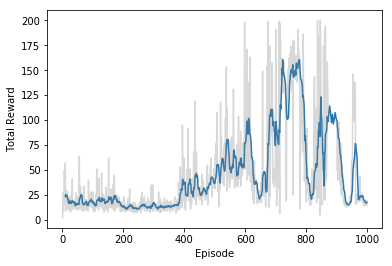

In [11]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')